In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import pyfolio as pf

# Download historical data using yfinance
ticker = '^NSEI'  # Example: NSE Index (replace with your preferred ticker)
data = yf.download(ticker, start='2019-01-01', end='2024-12-31')

# Parameters
length = 20
mult = 2.0
stop_loss_perc = 1 / 100
initial_portfolio_value = 1000000  # Starting portfolio value (1,000,000)

# Bollinger Bands Calculation
data['basis'] = data['Close'].rolling(window=length).mean()
data['stddev'] = data['Close'].rolling(window=length).std()
data['upper_band'] = data['basis'] + (mult * data['stddev'])
data['lower_band'] = data['basis'] - (mult * data['stddev'])



C:\Users\shahc\anaconda3\lib\site-packages\pyfolio\pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(
[*********************100%***********************]  1 of 1 completed


C:\Users\shahc\anaconda3\lib\site-packages\pyfolio\timeseries.py:1235: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  period = returns_dupe.loc[start:end]


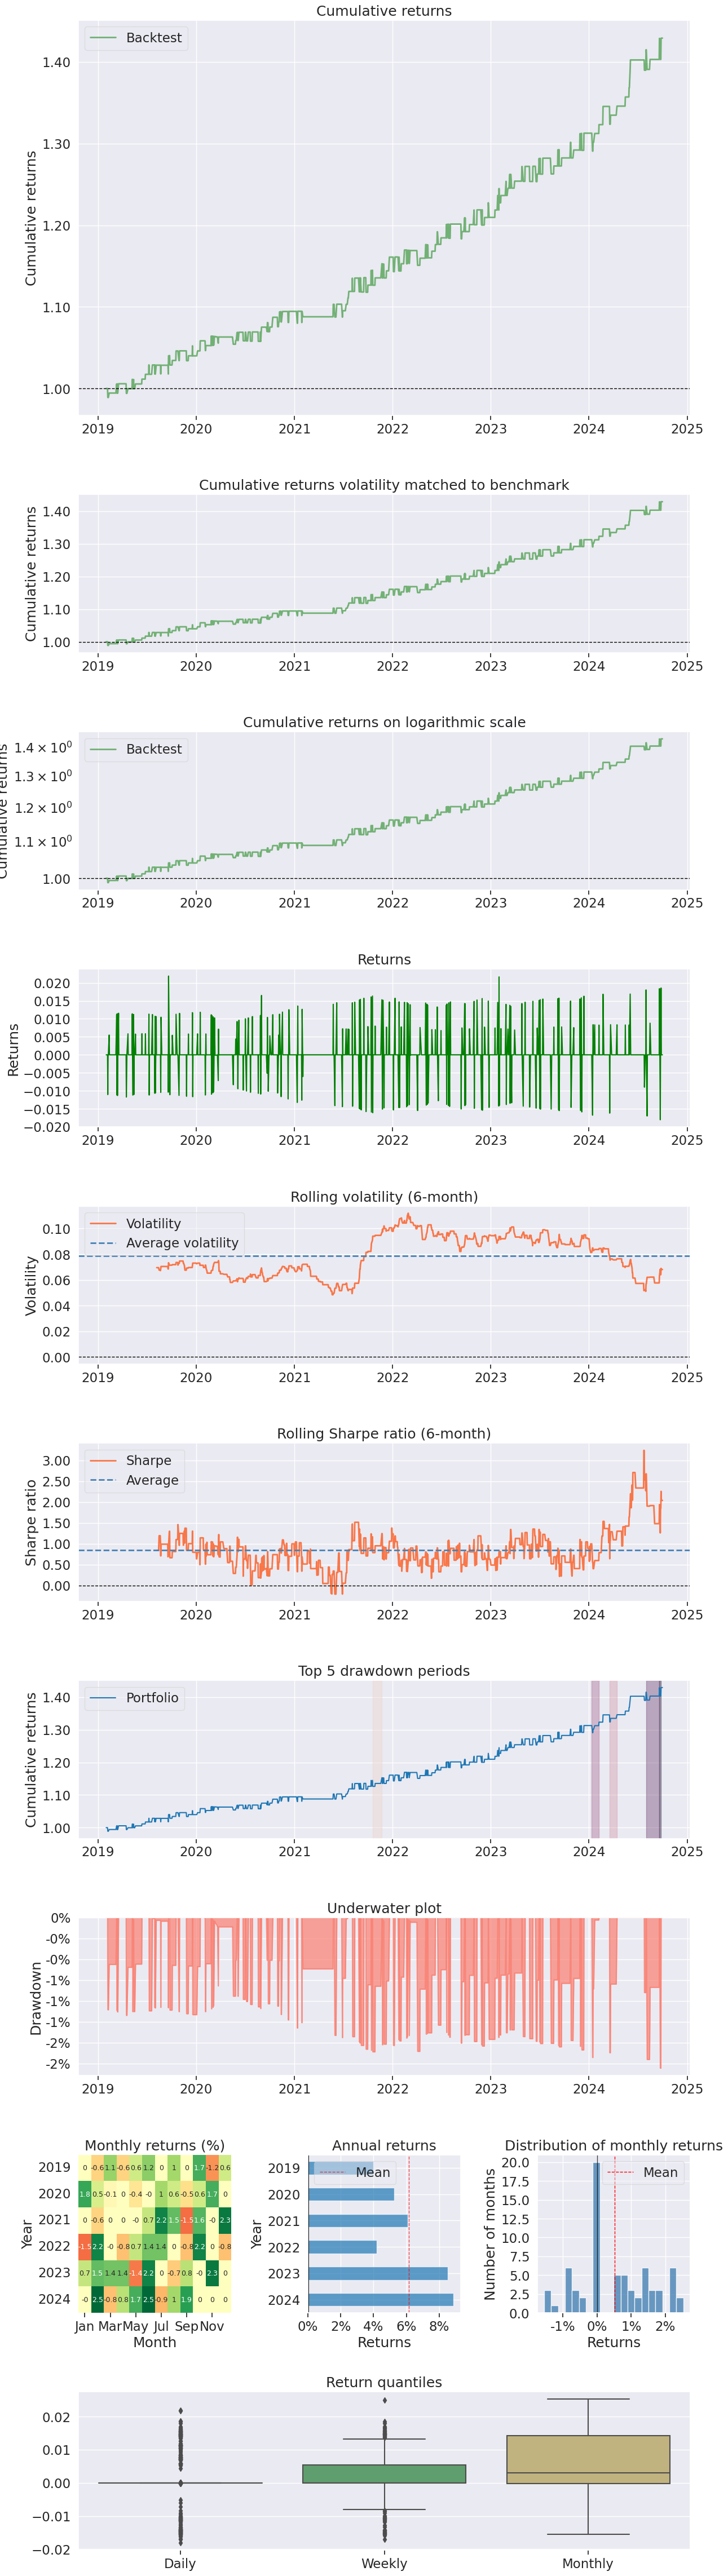

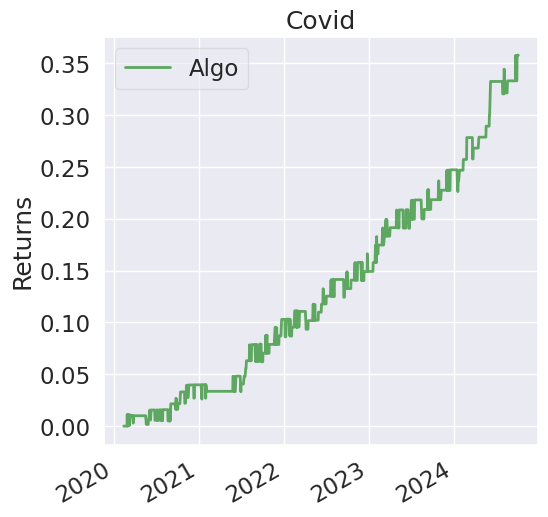

In [2]:
# Initialize trade variables
trade_in_progress_long = 0
trade_in_progress_short = 0
entry_price_long = np.nan
entry_price_short = np.nan
stop_loss_long = np.nan
stop_loss_short = np.nan
portfolio_value = initial_portfolio_value
all_trades = []  # Store all trades
portfolio_values = []  # To store portfolio value after each trade
dates = []  # To store corresponding dates

# Simulate the strategy
for i in range(length, len(data)):
    close_price = data['Close'].iloc[i]
    open_price = data['Open'].iloc[i]
    High = data['High'].iloc[i]
    Low = data['Low'].iloc[i]
    upper_band = data['upper_band'].iloc[i]
    lower_band = data['lower_band'].iloc[i]
    middle_band = data['basis'].iloc[i]
    
    # Long Entry Condition
    if Low <= lower_band and trade_in_progress_long == 0:
        entry_price_long = lower_band
        stop_loss_long = entry_price_long * (1 - stop_loss_perc)
        trade_in_progress_long = 2
        all_trades.append((data.index[i], 'Long Entry', lower_band))
        portfolio_value -= entry_price_long  # Update portfolio on entry

    # Long Partial Exit at Middle Bollinger Band
    if High >= middle_band and trade_in_progress_long == 2:
        all_trades.append((data.index[i], 'Long 50% Exit', middle_band))
        trade_in_progress_long = 1
        portfolio_value += middle_band * 0.5  # Add 50% of the position to portfolio value

    # Long Final Exit at Upper Bollinger Band
    if trade_in_progress_long > 0 and High >= upper_band:
        all_trades.append((data.index[i], 'Long Final Exit', upper_band))
        portfolio_value += upper_band  # Add remaining position to portfolio value
        trade_in_progress_long = 0

    # Long Stop Loss Enforcement
    if trade_in_progress_long > 0 and Low <= stop_loss_long:
        all_trades.append((data.index[i], 'Long Stop Loss Hit', stop_loss_long))
        portfolio_value += stop_loss_long  # Update portfolio value on stop loss
        trade_in_progress_long = 0

    # Short Entry Condition
    if High >= upper_band and trade_in_progress_short == 0:
        entry_price_short = upper_band
        stop_loss_short = entry_price_short * (1 + stop_loss_perc)
        trade_in_progress_short = 2
        all_trades.append((data.index[i], 'Short Entry', upper_band))
        portfolio_value -= entry_price_short  # Update portfolio on entry

    # Short Partial Exit at Middle Bollinger Band
    if Low <= middle_band and trade_in_progress_short == 2:
        all_trades.append((data.index[i], 'Short 50% Exit', middle_band))
        trade_in_progress_short = 1
        portfolio_value += middle_band * 0.5  # Add 50% of the position to portfolio value

    # Short Final Exit at Lower Bollinger Band
    if trade_in_progress_short > 0 and Low <= lower_band:
        all_trades.append((data.index[i], 'Short Final Exit', lower_band))
        portfolio_value += lower_band  # Add remaining position to portfolio value
        trade_in_progress_short = 0

    # Short Stop Loss Enforcement
    if trade_in_progress_short > 0 and High >= stop_loss_short:
        all_trades.append((data.index[i], 'Short Stop Loss Hit', stop_loss_short))
        portfolio_value += stop_loss_short  # Update portfolio value on stop loss
        trade_in_progress_short = 0

    # Track portfolio value for each day
    portfolio_values.append(portfolio_value)
    dates.append(data.index[i])

# Step 1: Create DataFrame with portfolio values
portfolio_df = pd.DataFrame({
    'date': dates,
    'portfolio_value': portfolio_values
})

# Step 2: Calculate daily returns (percentage change)
portfolio_df['daily_returns'] = portfolio_df['portfolio_value'].pct_change()

# Set 'date' as index
portfolio_df.set_index('date', inplace=True)

# Drop NaN values (if any, from the first day due to pct_change)
portfolio_df.dropna(inplace=True)

# Step 3: Analyze using PyFolio
pf.create_full_tear_sheet(portfolio_df['daily_returns'])


In [3]:
import plotly.graph_objects as go

def plot_trades(data, all_trades):
    # Create candlestick chart
    candlestick = go.Candlestick(
        x=data.index,
        open=data['Open'],
        high=data['High'],
        low=data['Low'],
        close=data['Close'],
        name='OHLC',
        increasing_line_color='green', 
        decreasing_line_color='red'
    )

    # Bollinger Bands
    upper_band_trace = go.Scatter(
        x=data.index, 
        y=data['upper_band'], 
        line=dict(color='rgba(255, 0, 0, 0.75)', width=1.5), 
        name='Upper Bollinger Band'
    )

    middle_band_trace = go.Scatter(
        x=data.index, 
        y=data['basis'], 
        line=dict(color='blue', width=1.5), 
        name='Middle Bollinger Band'
    )

    lower_band_trace = go.Scatter(
        x=data.index, 
        y=data['lower_band'], 
        line=dict(color='rgba(0, 255, 0, 0.75)', width=1.5), 
        name='Lower Bollinger Band'
    )

    # Add trade markers for both long and short trades
    trade_markers = []
    for trade in all_trades:
        date, action, price = trade
        
        if 'Long' in action:
            if action == 'Long Entry':
                trade_markers.append(go.Scatter(
                    x=[date],
                    y=[price],
                    mode='markers',
                    marker=dict(color='blue', size=10, symbol='triangle-up'),
                    name='Long Entry'
                ))
            elif action == 'Long 50% Exit':
                trade_markers.append(go.Scatter(
                    x=[date],
                    y=[price],
                    mode='markers',
                    marker=dict(color='yellow', size=10, symbol='triangle-up'),
                    name='Long 50% Exit'
                ))
            elif action == 'Long Final Exit':
                trade_markers.append(go.Scatter(
                    x=[date],
                    y=[price],
                    mode='markers',
                    marker=dict(color='red', size=10, symbol='triangle-up'),
                    name='Long Final Exit'
                ))
            elif action == 'Long Stop Loss Hit':
                trade_markers.append(go.Scatter(
                    x=[date],
                    y=[price],
                    mode='markers',
                    marker=dict(color='green', size=10, symbol='circle'),
                    name='Long Stop Loss Hit'
                ))
                
        elif 'Short' in action:
            if action == 'Short Entry':
                trade_markers.append(go.Scatter(
                    x=[date],
                    y=[price],
                    mode='markers',
                    marker=dict(color='blue', size=10, symbol='triangle-down'),
                    name='Short Entry'
                ))
            elif action == 'Short 50% Exit':
                trade_markers.append(go.Scatter(
                    x=[date],
                    y=[price],
                    mode='markers',
                    marker=dict(color='yellow', size=10, symbol='triangle-down'),
                    name='Short 50% Exit'
                ))
            elif action == 'Short Final Exit':
                trade_markers.append(go.Scatter(
                    x=[date],
                    y=[price],
                    mode='markers',
                    marker=dict(color='red', size=10, symbol='triangle-down'),
                    name='Short Final Exit'
                ))
            elif action == 'Short Stop Loss Hit':
                trade_markers.append(go.Scatter(
                    x=[date],
                    y=[price],
                    mode='markers',
                    marker=dict(color='orange', size=10, symbol='x'),
                    name='Short Stop Loss Hit'
                ))

    # Layout for the chart
    layout = go.Layout(
        title=f"Bollinger Bands and OHLC for {ticker} (Combined Trades)",
        xaxis_title="Date",
        yaxis_title="Price",
        xaxis_rangeslider_visible=False,
        template="plotly_dark"
    )

    # Combine all traces and plot
    fig = go.Figure(data=[candlestick, upper_band_trace, middle_band_trace, lower_band_trace] + trade_markers, layout=layout)
    fig.show()

# Call the function after running your trading strategy
plot_trades(data, all_trades)


In [4]:
def print_trade_details(all_trades):
    print(f"{'Date':<15} {'Action':<20} {'Price':<10}")
    print("-" * 45)  # Separator line
    for trade in all_trades:
        date, action, price = trade
        print(f"{date.strftime('%Y-%m-%d'):<15} {action:<20} {price:.2f}")

# Call the function after your trading strategy
print_trade_details(all_trades)


Date            Action               Price     
---------------------------------------------
2019-02-06      Short Entry          11059.86
2019-02-11      Short 50% Exit       10871.83
2019-03-11      Short Stop Loss Hit  11170.46
2019-03-12      Short Entry          11228.37
2019-03-13      Short Stop Loss Hit  11340.65
2019-03-14      Short Entry          11377.44
2019-03-18      Short Stop Loss Hit  11491.21
2019-04-16      Short Entry          11799.37
2019-04-22      Short 50% Exit       11602.32
2019-05-07      Long Entry           11504.52
2019-05-07      Short Final Exit     11504.52
2019-05-08      Long Stop Loss Hit   11389.48
2019-05-09      Long Entry           11373.97
2019-05-09      Long Stop Loss Hit   11260.23
2019-05-10      Long Entry           11313.44
2019-05-13      Long Stop Loss Hit   11200.31
2019-05-14      Long Entry           11171.13
2019-05-20      Long 50% Exit        11514.35
2019-05-23      Long Final Exit      11986.54
2019-05-23      Short Entry     